In [15]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
import Categorization
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
from PIL import Image
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [37]:
data = pd.read_csv("./categorisedData/clusteredData.csv")

# target = data['deathperiod']
target = data['Mortality14Days']

data = data.set_index('PatientID')

# data = data.drop('deathperiod', axis=1)
data = data.drop('Mortality14Days', axis=1)

data

,Arterial BP Mean_StdDev_high,Arterial BP Mean_StdDev_low,Arterial BP Mean_Mean_high,Arterial BP Mean_Mean_low,Arterial BP [Diastolic]_StdDev_high,Arterial BP [Diastolic]_StdDev_low,Arterial BP [Diastolic]_Mean_high,Arterial BP [Diastolic]_Mean_low,Arterial BP [Systolic]_StdDev_high,Arterial BP [Systolic]_StdDev_low,...,Platelets_Mean_low,Platelets_Mean_medium,SVR_StdDev_high,SVR_StdDev_low,SVR_Mean_high,SVR_Mean_low,SVRI_StdDev_high,SVRI_StdDev_low,SVRI_Mean_high,SVRI_Mean_low
PatientID,,,,,,,,,,,,,,,,,,,,,
178177,1,0,1,0,1,0,1,0,0,1,...,0,1,1,0,1,0,1,0,1,0
110594,1,0,1,0,0,1,0,1,0,1,...,1,0,0,1,0,1,0,1,0,1
157699,0,1,0,1,1,0,1,0,0,1,...,1,0,0,1,0,1,0,1,0,1
180230,0,1,0,1,0,1,0,1,0,1,...,0,0,0,1,0,1,0,1,0,1
165898,1,0,1,0,1,0,1,0,0,1,...,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196597,0,1,0,1,0,1,0,1,0,1,...,0,1,1,0,1,0,1,0,1,0
116726,0,1,0,1,0,1,0,1,0,1,...,1,0,0,1,0,1,0,1,0,1
169975,0,1,0,1,1,0,1,0,0,1,...,0,1,1,0,1,0,1,0,1,0


0.47967479674796754

0.4732620320855615

0.48626373626373626

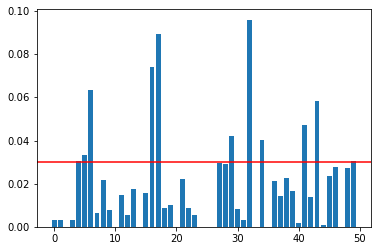

In [38]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

display(f1_score(y_test, y_pred, average='macro'))
display(recall_score(y_test, y_pred, average='macro'))
display(precision_score(y_test, y_pred, average='macro'))

thresh = 0.03

imp = clf.feature_importances_
plt.bar(list(range(len(imp))), imp)
plt.axhline(y=thresh, color='r')
plt.show()

['Arterial BP [Diastolic]_StdDev_high',
 'Arterial BP [Diastolic]_StdDev_low',
 'Arterial BP [Diastolic]_Mean_high',
 'Arterial PaO2_StdDev_high',
 'Arterial PaO2_StdDev_low',
 'Hemoglobin_StdDev_low',
 'Ionized Calcium_StdDev_high',
 'Ionized Calcium_Mean_high',
 'Platelets_Mean_medium',
 'SVR_StdDev_low',
 'SVRI_Mean_low']

In [6]:
featuresToKeep = [clf.feature_names_in_[i] for i in range(len(imp)) if imp[i] > thresh]

featuresToKeep

featureSelectedDF = data[featuresToKeep]
featureSelectedDF['Mortality14Days'] = target.values
featureSelectedDF

C:\Users\benma\AppData\Local\Temp/ipykernel_19084/222637761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featureSelectedDF['Mortality14Days'] = target.values


,Arterial BP [Diastolic]_StdDev_high,Arterial BP [Diastolic]_StdDev_low,Arterial BP [Diastolic]_Mean_high,Arterial PaO2_StdDev_high,Arterial PaO2_StdDev_low,Hemoglobin_StdDev_low,Ionized Calcium_StdDev_high,Ionized Calcium_Mean_high,Platelets_Mean_medium,SVR_StdDev_low,SVRI_Mean_low,Mortality14Days
PatientID,,,,,,,,,,,,
178177,1,0,1,1,0,1,0,1,1,0,0,0
110594,0,1,0,0,1,1,0,1,0,1,1,0
157699,1,0,1,1,0,1,0,1,0,1,1,0
180230,0,1,0,1,0,1,1,0,0,1,1,0
165898,1,0,1,0,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
196597,0,1,0,0,1,1,1,0,1,0,0,0
116726,0,1,0,0,1,1,1,0,0,1,1,0
169975,1,0,1,0,1,1,0,1,1,0,0,0


In [103]:
featureSelectedDF.to_csv("./categorisedData/expertLabelledDataSimple_featureSelected.csv")

0.4934036939313984

0.5

c:\Users\benma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4869791666666667

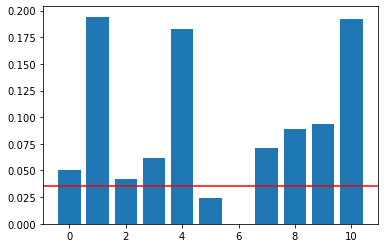

In [35]:
data = featureSelectedDF.drop('Mortality14Days', axis=1)

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

display(f1_score(y_test, y_pred, average='macro'))
display(recall_score(y_test, y_pred, average='macro'))
display(precision_score(y_test, y_pred, average='macro'))

imp = clf.feature_importances_
plt.bar(list(range(len(imp))), imp)
plt.axhline(y=0.035, color='r')
plt.show()

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

[[0 1 0 ... 1 0 1]
 [0 1 0 ... 0 1 0]
 [0 1 0 ... 1 0 1]
 ...
 [0 1 0 ... 1 0 1]
 [1 0 1 ... 1 0 1]
 [0 1 0 ... 0 1 0]]


0.4852546916890081

0.4839572192513369

0.48655913978494625

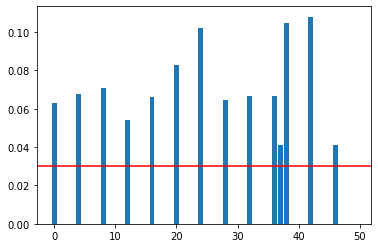

In [40]:
x_train, x_test, y_train, y_test = train_test_split(data.to_numpy(), target, test_size=0.2, random_state=0)

clf = XGBClassifier()

print(x_train)

clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)


# print(y_pred, y_test)

display(f1_score(y_test, y_pred, average='macro'))
display(recall_score(y_test, y_pred, average='macro'))
display(precision_score(y_test, y_pred, average='macro'))

thresh = 0.03

imp = clf.feature_importances_
plt.bar(list(range(len(imp))), imp)
plt.axhline(y=thresh, color='r')
plt.show()

In [41]:
featuresToKeep = [data.columns[i] for i in range(len(imp)) if imp[i] > thresh]

featuresToKeep

featureSelectedDF = data[featuresToKeep]
featureSelectedDF['Mortality14Days'] = target.values
featureSelectedDF


C:\Users\benma\AppData\Local\Temp/ipykernel_19084/2506733088.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featureSelectedDF['Mortality14Days'] = target.values


,Arterial BP Mean_StdDev_high,Arterial BP [Diastolic]_StdDev_high,Arterial BP [Systolic]_StdDev_high,Arterial PaCO2_StdDev_high,Arterial PaO2_StdDev_high,Arterial pH_StdDev_high,CVP_StdDev_high,Hemoglobin_StdDev_high,Ionized Calcium_StdDev_high,Platelets_StdDev_high,Platelets_StdDev_low,Platelets_StdDev_medium,SVR_StdDev_high,SVRI_StdDev_high,Mortality14Days
PatientID,,,,,,,,,,,,,,,
178177,1,1,0,1,1,0,0,0,0,0,0,1,1,1,0
110594,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0
157699,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0
180230,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0
165898,1,1,0,1,0,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196597,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0
116726,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0
169975,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0


In [42]:
target.value_counts()

0    924
1     35
Name: Mortality14Days, dtype: int64

In [43]:
featureSelectedDF.to_csv("./categorisedData/categorisedData_featureSelected.csv")